problems:
* For the grey group, I just use all features in grey groups as split_var in lmertree with no regressors and choose the ones used by the tree (REEM)
* After selecting features from all modules, I use them as split_var (and no regressors) in lmertree and select again. I think there are better ways. For examples, we can use REEM forest and use varImp
* In terms of prediction, this current implementation does not have significant advantage over Fuzzy Forest (which cannot deal with time), sometimes worse in prediction and feature selection. Of course, if we are using data that have a time dependence, we may see the difference. Also, lmertree is designed for clustered data. Our sim_3 in fact is not a very good example of longitudinal/clustered data that can be dealt with my lmertree

In [1]:
# This is a automatic version of longitudinal Fuzzy Model Tree

In [ ]:
# install.packages("partykit")
# install.packages("pre")
library("partykit")
source("SimData.r")
library("party")
library(MASS)
library("glmertree")
library("caret") # importance and rfe
source("SimData.r")
library("randomForest")
library("rpart")
library("fuzzyforest")
library("WGCNA")
library("pre")

# Data

In [18]:
# training data
n <- 100 # number of patients
T <-  5 # number of observations per patients

# set.seed(100)

data <- as.data.frame(sim_3(n, T)) 
colnames(data)[401] <- "y"

# time-dependent dara
# data = sim_5(n,T)

# add patient/cluster information
for (i in 1:n){
    data$patient[(1+(i-1)*T):(i*T)] = rep(i,T)
}

data[1:10,]

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V396,V397,V398,V399,V400,time,group1,group2,y,patient
0.9380455,0.39832023,0.43576118,0.5604594,0.87629925,-0.0355260,0.61422678,0.2731034,1.20806381,0.95445911,...,0.67313572,0.1758420,0.68174953,-0.837880698,-0.03626415,1,1,0,12.045177,1
-0.6287452,0.10670250,0.04527866,-0.3518300,-0.42132845,-0.2004668,-0.14233497,0.1051778,0.55245098,-0.34952155,...,0.64634771,-0.8296392,-1.11745852,0.881466524,1.43457631,2,1,0,-13.818223,1
1.4834441,1.10496146,1.68445604,1.8060788,1.54087138,1.1237299,0.08835985,1.0022010,1.46346965,1.01777816,...,0.26224847,-0.6998452,-1.41014031,0.758169397,1.24965279,3,1,0,6.800999,1
1.6047251,0.85834581,0.82378566,1.1004389,0.54256111,0.9812542,0.85592163,1.1583824,1.01901539,0.97110382,...,-0.08497913,-1.4973463,-2.50708784,-0.683802633,0.21223444,4,1,0,25.012531,1
0.2020758,0.52370083,0.48897503,0.7022059,0.07911032,0.1328832,0.35394004,0.2410072,0.27840256,0.48366404,...,0.19321063,1.7805300,-0.49734227,-0.028260438,0.32645950,5,1,0,15.281388,1
1.4276282,1.34401726,1.61011362,0.2469424,1.86037978,1.5175600,1.20274586,1.4490959,1.51582264,0.55453627,...,-1.79326522,-0.4427739,0.53555113,2.128370529,0.08434533,1,1,0,35.184791,2
0.9452251,0.13901195,0.05592316,0.6434391,0.52076353,0.8890303,0.28994428,0.0730105,0.43857326,0.19979316,...,-0.26442073,1.7547326,0.08388318,-1.005398948,-0.51623958,2,1,0,-5.147759,2
-0.4460599,-1.00149250,-1.33473194,-0.2568974,-0.82048377,-1.0981459,-0.85048987,-0.8319112,0.02613766,-0.57932273,...,0.85588381,-0.9993652,-0.35442011,-0.770427990,0.73355390,3,1,0,-10.706139,2
-0.3493267,-0.96735257,-0.84591130,-0.4600642,-0.61641658,-1.4230633,-0.86146429,-0.4331970,-0.69327737,-0.75510648,...,2.39045777,-1.0279991,-0.39662239,-1.808998315,0.59387884,4,1,0,-3.331180,2
0.1887914,0.04988618,-0.11188132,1.1517454,0.26562815,0.2720118,0.43697711,0.3071168,0.64227672,0.02025777,...,0.77297401,0.2498793,-1.40923863,0.005298877,-1.76424813,5,1,0,23.682162,2


In [19]:
# test data
n_test <- 30 
T <-  5 # number of observations per patients

# set.seed(101)
data_test <- as.data.frame(sim_3(n_test, T)) 
colnames(data_test)[401] <- "y"

# time-dependent dara
# data_test = sim_5(n_test,T)

# add patient/cluster information
for (i in 1:n_test){
    data_test$patient[(1+(i-1)*T):(i*T)] = rep(i,T)
}

data_test[1:10,]

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V396,V397,V398,V399,V400,time,group1,group2,y,patient
-0.2962047,-0.5894044,-0.5570795,-1.4009140,0.31033748,0.4030668,-1.0783885,-0.7525371,-0.6758267,-0.33407043,...,-1.09783096,-0.6381292,1.4043886,-1.0541634,-1.4427202,1,1,0,6.1608057,1
-0.8015575,-0.1551302,-0.4964006,-0.8055954,-1.00229430,-0.6332812,-1.4924106,-0.7301448,-1.4294956,-1.32013962,...,-0.19167154,-0.1493140,-0.4684420,0.4699358,0.3512918,2,1,0,-12.5100989,1
-1.0517934,-0.5868447,-0.6560658,-0.7732399,-1.08786975,-0.3669450,-0.4563233,0.1147359,-0.4322921,-0.42458696,...,-1.25117690,-0.6544705,1.9784236,-0.5428707,1.4876389,3,1,0,-16.3991257,1
-1.7504120,-0.9467730,-1.8170057,-2.0369183,-1.62291768,-2.1951140,-1.5044861,-1.8667090,-1.7926501,-1.55219899,...,0.65813297,0.3168678,0.4144254,-0.4286621,-0.3240954,4,1,0,-8.4919327,1
-0.7273936,-1.9551606,-1.7210528,-1.4971564,-0.83486791,-0.9990539,-1.5045973,-1.7494430,-1.6901496,-0.82353038,...,-0.69810519,-0.5062203,-0.7238179,-2.4732729,2.9741349,5,1,0,7.8912185,1
-0.7481885,-0.9606916,-1.2269821,-1.0257193,-1.76295185,-0.9274072,-1.0720566,-0.3139351,-0.9967573,-1.22021773,...,0.86281178,0.5200689,-0.9675749,-0.4585492,-0.5182958,1,1,0,12.7774252,2
1.1955590,0.3664124,0.2772692,-0.5098862,0.06682449,0.9248364,0.8186040,-0.1186250,0.3364809,-0.06642837,...,-1.46479750,0.1161700,-1.2503399,-1.5571344,1.2559614,2,1,0,6.5346588,2
0.3177758,0.6806738,0.3083053,0.8549001,0.30640297,0.2661756,1.3841112,0.1595284,0.7683191,0.71641548,...,0.05794306,0.9667938,0.3848058,0.6122971,-2.2262203,3,1,0,-0.1827775,2
-1.3543136,-0.8797844,-0.4165368,-1.7826015,-1.01495230,-0.6243194,-1.2295471,-1.4529257,-1.6643934,-0.76231198,...,0.32810381,1.8712292,-0.1390349,0.2521843,1.4198860,4,1,0,-7.3191564,2
1.3322596,0.6502779,0.5703921,0.9263554,1.21475636,1.2502490,0.5684483,1.2966800,1.2523498,0.88706823,...,-0.12418129,0.4608948,-0.9838120,0.9295415,2.0673124,5,1,0,26.5763590,2


In [20]:
# Methods for extracting names of splitting features used in a tree
# tree: a tree object; data: the train or test set
get_split_names = function(tree,data){
    # path: the string that contains all the node information
    paths <- pre:::list.rules(tree, removecomplements = FALSE)
    vnames = names(data)
    # the regex for a variable
    # tomatch = paste(paste(var,"<="),"|",paste(var,">"),sep="")
    # match to tomatch in path
    tmp = vnames[sapply(sapply(vnames, FUN = function(var) grep(paste(paste(var,"<="),"|",paste(var,">"),sep=""), paths)), length) > 0]
    return (tmp)
}

# WGCNA Step

In [7]:
# # Only use the features 1:400
# data_WGCNA = data[,1:400]

# # Choose a set of soft-thresholding powers
# powers = c(c(1:10), seq(from = 12, to=20, by=2))
# # Call the network topology analysis function
# sft = pickSoftThreshold(data_WGCNA, powerVector = powers, verbose = 5)
# # Plot the results:
# # sizeGrWindow(9, 5) # not using in jupyternotebook
# par(mfrow = c(1,2));
# cex1 = 0.9;
# # Scale-free topology fit index as a function of the soft-thresholding power
# plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
#      xlab="Soft Threshold (power)",
#      ylab="Scale Free Topology Model Fit,signed R^2",type="n",
#      main = paste("Scale independence"))
# text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
#      labels=powers,cex=cex1,col="red");
# # this line corresponds to using an R^2 cut-off of h
# abline(h=0.90,col="red")
# # Mean connectivity as a function of the soft-thresholding power
# plot(sft$fitIndices[,1], sft$fitIndices[,5],
#      xlab="Soft Threshold (power)",ylab="Mean Connectivity", 
#      type="n",main = paste("Mean connectivity"))
# text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="red")

In [8]:
data_WGCNA = data[,1:400] # only the covariates
# choose power = 6, which is not quite correct
# Please set numericLabels = FALSE so that the label is one color (string)
# if verbose = 3, show some details
net = blockwiseModules(data_WGCNA, power = 6,TOMType = "unsigned", 
                       minModuleSize = 30,reassignThreshold = 0, 
                       mergeCutHeight = 0.25,numericLabels = FALSE, 
                       pamRespectsDendro = FALSE,verbose = 0)

# the correspondance betweeen feature names and colors
colors = net$colors # it is a string vector with names (that is the name is V1)

In [9]:
# Get a list with the first element being all the names of first groups and so on
# all the names of modules
module_names = unique(colors) # all colors name

# a vector with name(index) = names of modules and value = the corresponding names
# of features (like a dictionary)
module_dic = list()
for (i in 1:length(module_names)){
    module_dic[[module_names[i]]] = names(colors[colors==module_names[i]])
}
# module_dic

In [10]:
# extract eigengenes and rename the column
# The eigengene(1st pricinpal component) is L2 normalized
eigengene = net$MEs
# eigengene
# add eigengen to training data
for (name in module_names){
    if (name == "grey"){
        next
    }
    eigen_name = paste("ME",name,sep="")
    data[[eigen_name]] = eigengene[[eigen_name]]
}
# head(data)

# Model tree step

In [27]:
imp_var = list() # used to store the names of important features
cluster_var = "patient" # the name should be specified by the users

# for time dependent data
# cluster_var = "group"

# For each module that is not grey, use model tree as following:
# use its eigengene as regression variables and all features as splitting ones
# For grey module, use regular REEM (set regressor = "1")
# Finally, use all the chosen features for splitting and regression variables

# for non-grey groups
for (name in module_names){
    if (name == "grey"){
        next
    }
    split_var = module_dic[[name]]
    
    # use eigengene as regressor
    eigen_name = paste("ME",name,sep="")
    regress_var = eigen_name
    
    # Formula for lmtree: use PC as regressors
    Formula = as.formula(paste("y~",paste(regress_var,collapse = "+"),
                           "|",cluster_var,"|",
                         paste(split_var,collapse = "+")))
    # test: if just use GUIDE (no regressors)
#     Formula = as.formula(paste("y~",paste(split_var,collapse = "+")))
    
    # fit the tree
    mytree = lmertree(Formula, data = data,alpha = 0.2,maxdepth=5) 
    
    #extract important features
    imp_var[[length(imp_var)+1]] = get_split_names(mytree$tree,data)
    
#     plot(mytree)
    flush.console()
    cat("\n",get_split_names(mytree$tree,data),"\n")
    # to print the error, we have to add PC to test data
#     print(mean((predict(mytree,newdata=data_test)-data_test$y)**2))
}

# # for grey group, do not use any regressor, just regular REEM
split_var = module_dic[["grey"]]
regress_var = ""
Formula = as.formula(paste("y~","1",
                           "|",cluster_var,"|",
                         paste(split_var,collapse = "+")))
mytree = lmertree(Formula, data = data,alpha = 0.2,maxdepth=5) 
imp_var[[length(imp_var)+1]] = get_split_names(mytree$tree,data)

imp_var 


 V2 V3 V51 

 V166 V169 

 V204 


[[1]]
[1] "V2"  "V3"  "V51"

[[2]]
[1] "V166" "V169"

[[3]]
[1] "V204"

[[4]]
[1] "V301" "V302" "V367"

In [28]:
# the variables selected from all the modules
final_var = imp_var[[1]]
if (length(imp_var)>1){
    for (i in 2:length(imp_var)){
    final_var = c(final_var,imp_var[[i]])
 }
}
final_var

[1] "V2"   "V3"   "V51"  "V166" "V169" "V204" "V301" "V302" "V367"

In [29]:
# Not sure about this: select features again
# use all selected features as split_var in lmertree, with no regressors
Formula = as.formula(paste("y~","1",
                           "|",cluster_var,"|",
                         paste(final_var,collapse = "+")))
mytree = lmertree(Formula, data = data,alpha = 0.2,maxdepth=8) 
final_var = get_split_names(mytree$tree,data)
final_var

[1] "V2"   "V3"   "V51"  "V169" "V301" "V302"

In [30]:
# final_var = paste("V",c(1,2,3,301,302,303),sep="") # if cheating
# final_var = paste("V",c(1,2,3,301,302,303,5,99,107,293),sep="")  # perturbation

In [32]:
# use the final features as split&regression variables
Formula = as.formula(paste("y~",paste(final_var,collapse = "+"),
                           "|",cluster_var,"|",
                         paste(final_var,collapse = "+")))
mytree = lmertree(Formula, data = data,alpha = 0.2,maxdepth=8) 

In [33]:
mean((predict(mytree,newdata=data_test)-data_test$y)**2)
# plot(mytree)

[1] 36.35437

# Benchmark

## REEM tree

## Fuzzy Forest

   user  system elapsed 
 169.73    4.38  216.62 

[1] 98.41556

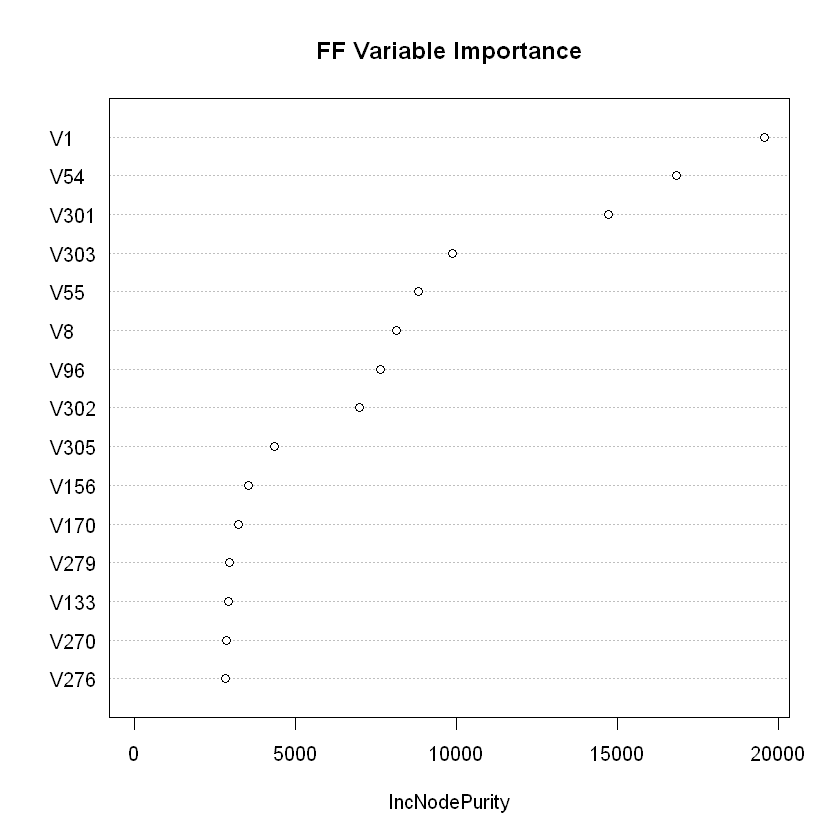

In [29]:
# Fuzzy Forest
# fuzzy forest
# Fuzzy Forest
# params is stored in xxx_control object
# power: belta (I choose it without much care)
WGCNA_params = WGCNA_control(power=3,TOMType="unsigned",minModuleSize=30,
                            numericLabels=TRUE,pamRespectsDendro=FALSE)

mtry_factor     = 1 # mtry = sqrt(p)*mtry_factor; mtry is the num in subspace method
drop_fraction   = 0.25 # drop xxx in each iteration of RFE-RF
number_selected = 15 # we want 10 out of all features
keep_fraction   = 0.05 # keep xxx for each module
min_ntree        = 500 # used for calculating ntree
ntree_factor    = 5 # used for calculating ntree
final_ntree     = 500 # RF in selecting step

screen_params = screen_control(drop_fraction = drop_fraction,
                              keep_fraction  = keep_fraction,
                              min_ntree      = min_ntree,
                              mtry_factor    = mtry_factor,
                              ntree_factor   = ntree_factor)

select_params = select_control(drop_fraction  = drop_fraction,
                              number_selected = number_selected,
                              min_ntree       = min_ntree,
                              mtry_factor     = mtry_factor,
                              ntree_factor    = ntree_factor)    

var = paste("V",1:400,sep="")
Formula = as.formula(paste("y~",paste(var,collapse = "+")))

# a "fuzzy_forest" object
system.time({
# set.seed(20)
wff_fit = wff(Formula,data = data,WGCNA_params = WGCNA_params,
             screen_params = screen_params,
             select_params = select_params,
             final_ntree = final_ntree)
})

mean((predict(wff_fit,new_data=data_test)-data_test$y)**2)
varImpPlot(wff_fit$final_rf,type=2,main="FF Variable Importance")

## Random Forest

   user  system elapsed 
  23.81    0.58   32.47 

[1] 104.9534

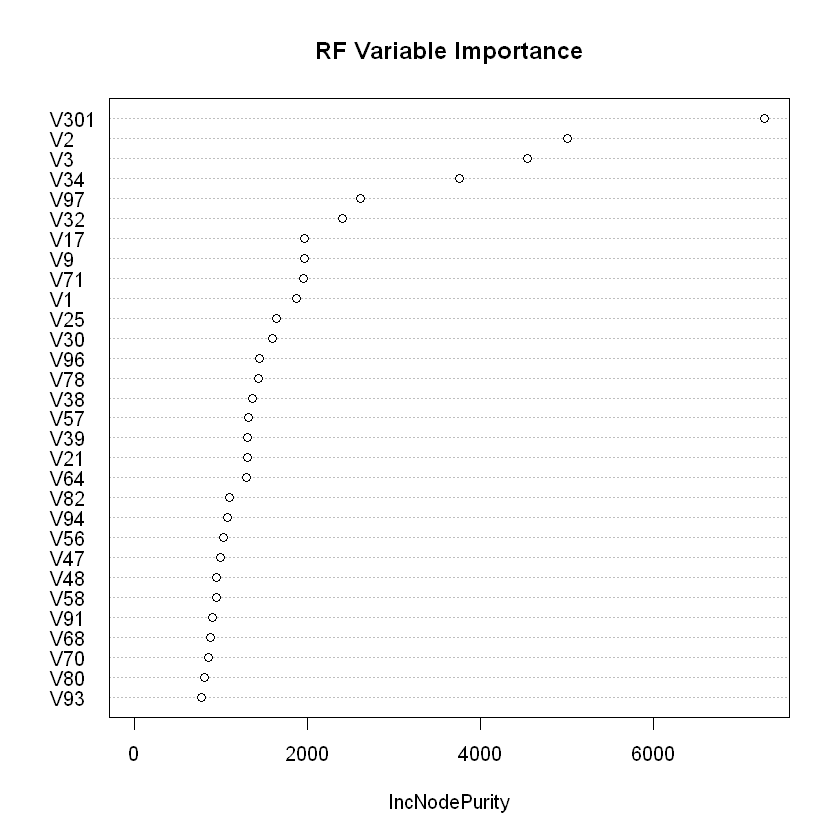

In [22]:
# Random Forest
system.time({
#     set.seed(20)
    rf <- randomForest(data[,1:400],data$y)
})
mean((predict(rf,newdata=data_test[,1:400])-data_test$y)**2)
varImpPlot(rf,type=2,main="RF Variable Importance")